# Intro
A basic genetic algorithm that tackles the travelling salesman problem (TSP).
In short, it searches for the shortest distance between however many cities you have selected in the setup. 
Each city is defined by an X,Y coordinate.



Data was taken from Kaggle

# Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import math

In [3]:
np.set_printoptions(suppress=True, linewidth = 250) # Suppress scientific notation

## Parameters

In [4]:
my_data = np.loadtxt('data/cities.csv', skiprows = 1, delimiter = ',')
nums = 100  # len(my_data) # number of rows from my_data to use
mutprob = 80  # mutation probability
swapprob = .05  # probability of an individual element of mutating
my_data = my_data[0:nums,:] 
its = 500  # number of generations
popsize = 100  # population size

## Functions

In [5]:
def mutate_swap2(route, nums, swapprob):
    
    # in: a route composed of 2 vectors
    # out: a new route composed of 2 vectors
    
    routenew = np.copy(route[:,0])
    mutelem = np.random.choice([0,1], size = nums, p = [1-swapprob, swapprob])  # array containing elems to mutate
    idx1 = np.where(mutelem == 1)  # indeces of 1's
    b = routenew[idx1]  # numbers at indices -> b
    np.random.shuffle(b)  # shuffle b
    routenew[idx1] = b  # set numbers in route ad indeces equal to b
    
    # Make route thing to return
    route2 = routenew[1:]
    route2 = np.append(route2, routenew[0])

    return(routenew.astype(int), route2.astype(int)) 
    

In [6]:
def crossover(parent1, parent2):
    
    # in: 2 parents
    # out: 2 offspring
    
    cutoff = random.randint(0,nums)  # random cutoff point
    
    parents1 = parent1[:,0]
    parents2 = parent2[:,0]
    
    offspring1 = np.full(len(parents1), -1).astype(int)  # create empty array
    offspring2 = np.full(len(parents2), -1).astype(int)  # create empty array
       
    offspring1[0:cutoff] = parents1[0:cutoff]  # stick parent 1 into first part
    offspring1[cutoff:] = parents2[~np.in1d(parents2,offspring1)]  # stick whatever legal numbers remain into the second
                                                                   # part of offspring, but in the order that they appear
                                                                   # in parent 2
                
    offspring2[0:cutoff] = parents2[0:cutoff]  # stick parent 2 into first part
    offspring2[cutoff:] = parents1[~np.in1d(parents1,offspring2)]  # stick whatever legal numbers remain into the second
                                                                   # part of offspring, but in the order that they appear
                                                                   # in parent 1
    
    # And now for some truly shoddy programming, the lines below generate 2 offspring from the above.
    offspring1b = offspring1[1:]
    offspring1b = np.append(offspring1b, offspring1[0])
    offspring2b = offspring2[1:]
    offspring2b = np.append(offspring2b, offspring2[0])
    offspring1c = np.column_stack((offspring1,offspring1b))
    offspring2c = np.column_stack((offspring2,offspring2b))
    
    return(offspring1c, offspring2c)
    

# Main loops

## Monte Carlo
Randomly chooses a route, checks fitness, keeps it if it is better than previous route, randomly choose new route.

In [7]:
old_distance = 1000000000000
my_dist = 0
distmat = np.zeros((its, 2))

for j in range(0,its):
    # makes 2 vectors a and b, where b is the same as a, other than that it is shifted along 1, so that
    # b[0] = a[1], a[0] is added to the end of b. In this way, the vectors form paths along which santa
    # can travel.
    a = np.arange(nums)
    np.random.shuffle(a)
    b = a[1:]
    b = np.append(b, a[0])
    route = np.column_stack((a,b))
    
    # take diagonal sum of euclidian distmat
    my_dist = np.trace(distance.cdist(my_data[a, 1:3], my_data[b, 1:3], 'euclidean')) 
    
    # If new distance is better than old distance, keep new distance and route
    # else keep old distance and route
    if my_dist < old_distance:
        old_distance = my_dist
        best_route = route        
    else:
         pass

    distmat[j,0] = j
    distmat[j,1] = old_distance
    my_dist = 0

routedata = my_data[best_route[:,0]]    

## Plots

### Plot best route

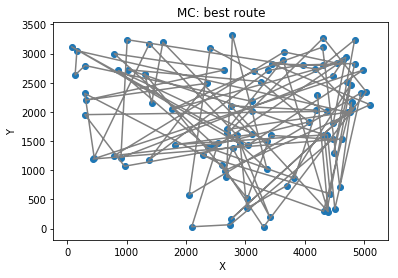

In [8]:
x = routedata[:,1]
y = routedata[:,2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, color = 'gray')
ax.scatter(x,y)
ax.set(title = "MC: best route", ylabel = 'Y', xlabel = ' X')
plt.show()

### Plot performance over generations

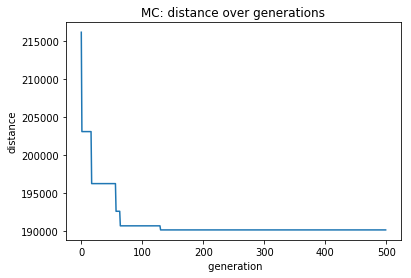

Shortest distance =  190201.5839104105


In [9]:
x = distmat[:,0]
y = distmat[:,1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set(title ="MC: distance over generations", ylabel = 'distance', xlabel = ' generation')
plt.show()
print('Shortest distance = ', min(distmat[:,1]))

## MUT + CO + elitist selection
Using crossover, mutation and (elitist) selection to find the best elements in the population.

In [10]:
# make parent 1
a = np.arange(nums)
np.random.shuffle(a)
b = a[1:]
b = np.append(b, a[0])
parent1 = np.column_stack((a,b))

# make parent 2
c = np.arange(nums)
np.random.shuffle(c)
d = c[1:]
d = np.append(d, c[0])
parent2 = np.column_stack((c,d))

# make empty arrays
offspring = np.zeros((nums,popsize))
optdistmat = np.zeros((its,2))


for i in range(0, its):
    
    distmat = np.zeros((4,1))  # set to zero, or distances from earlier generations will be added to new generation

    offspring1, offspring2 = crossover(parent1, parent2)  # 2 parents produce 2 offspring using crossover

    # Takes sum of diagonal of euclidian distance matrix = total distance
    distmat[0] = np.trace(distance.cdist(my_data[parent1[:,0], 1:3], my_data[parent1[:,1], 1:3], 'euclidean'))
    distmat[1] = np.trace(distance.cdist(my_data[parent2[:,0], 1:3], my_data[parent2[:,1], 1:3], 'euclidean'))
    distmat[2] = np.trace(distance.cdist(my_data[offspring1[:,0], 1:3], my_data[offspring1[:,1], 1:3], 'euclidean'))
    distmat[3] = np.trace(distance.cdist(my_data[offspring2[:,0], 1:3], my_data[offspring2[:,1], 1:3], 'euclidean'))
    
    best = np.argmin((distmat))  # Index of shortes distance out of 2 parents & 2 offspring
   
    # Dict to link indices to route
    whatdict = {
        0:parent1,
        1:parent2,
        2:offspring1,
        3:offspring2
    }
    
    parent = whatdict[best]  # best of all parents/offsprings offspring becomes new parent

    distmat = np.zeros((popsize,1))  # Reset to zero
    
    # Next, make a boolean vector to indicate whether a child is to be mutated (1) or not (0).
    choice = np.random.choice(np.arange(1,100),popsize)  # Vector of popsize numbers (1 - 100)
    mutate = choice <= mutprob  # Boolean vector, 1 if choice <= mutprob, else 0
    mutate = np.repeat(mutate, 2)  # Repeat so that the next for loop iterates across every element in mutate
    
    # Array containing popsize copies of parent
    offspring = np.repeat(parent, popsize, axis = 0).reshape(nums, popsize*2)
       
    # For every unit in population (which is initially just a copy of the best of 2 parents and 2 offspring)
    # See if you're going to mutate it
    # If so, replace unit with mutated copy, else: leave it
    for j in range(0, len(mutate),2):
        if mutate[j] == True:
            offspring[:, j], offspring[:, j+1] = mutate_swap2(parent, nums, swapprob)
        else:
             pass
    
    distmat = np.zeros((popsize,1))  # reset distance matrix to zero
    
    # Stick distances in array distmat
    for k in range(0, popsize):
        distmat[k] = np.trace(distance.cdist(my_data[offspring[:,k*2], 1:3], 
                                             my_data[offspring[:,k*2+1], 1:3], 'euclidean'))
    
    # Indices of best route
    best = np.argmin((distmat))
    bestindices = [best*2, best*2+1]  
       
    # Best offspring becomes new parent1    
    parent1 = offspring[:, bestindices].astype(int)  
    
    # Second best offspring becomes parent 2
    secondbest = np.argpartition(distmat, 2, axis = 0)[1,0]
    secondbestindices = [secondbest*2, secondbest*2+1]
    parent2 = offspring[:, secondbestindices].astype(int)
    
    # Stick data in array for plotting
    optdistmat[i,0] = i
    optdistmat[i,1] = distmat[best]
    
    # Reset distance to 0
    my_dist = 0
    
routedata = my_data[parent1[:,0]]


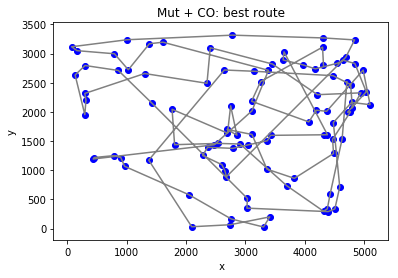

In [11]:
x = routedata[:,1]
y = routedata[:,2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, color = 'gray')
ax.scatter(x,y, color = 'blue')
ax.set(title = "Mut + CO: best route", ylabel = 'y', xlabel = ' x')
plt.show()

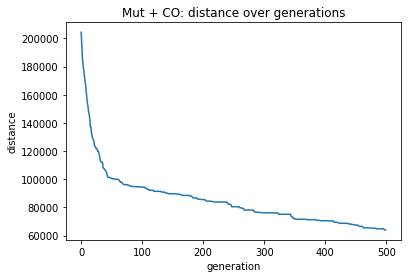

Shortest distance is 64057.5013453419


In [12]:
x = optdistmat[:,0]
y = optdistmat[:,1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set(title = "Mut + CO: distance over generations", ylabel = 'distance', xlabel = 'generation')
plt.show()
print('Shortest distance is', min(optdistmat[:,1]))

# Performance tests

In [13]:
runs = 20

## Monte Carlo

In [14]:
def main_MC():
    old_distance = 1000000000000
    my_dist = 0
    distmat = np.zeros((its, 2))

    for j in range(0,its):
        # makes 2 vectors a and b, where b is the same as a, other than that it is shifted along 1, so that
        # b[0] = a[1], a[0] is added to the end of b. In this way, the vectors form paths along which santa
        # can travel.
        a = np.arange(nums)
        np.random.shuffle(a)
        b = a[1:]
        b = np.append(b, a[0])
        route = np.column_stack((a,b))

        # take diagonal sum of euclidian distmat
        my_dist = np.trace(distance.cdist(my_data[a, 1:3], my_data[b, 1:3], 'euclidean')) 

        # If new distance is better than old distance, keep new distance and route
        # else keep old distance and route
        if my_dist < old_distance:
            old_distance = my_dist
            best_route = route        
        else:
             pass

        distmat[j,0] = j
        distmat[j,1] = old_distance
        my_dist = 0

    return(min(distmat[:,1]))

## Mutation + Crossover

In [15]:
def main_mutco():

    # make parent 1
    a = np.arange(nums)
    np.random.shuffle(a)
    b = a[1:]
    b = np.append(b, a[0])
    parent1 = np.column_stack((a,b))

    # make parent 2
    c = np.arange(nums)
    np.random.shuffle(c)
    d = c[1:]
    d = np.append(d, c[0])
    parent2 = np.column_stack((c,d))

    # make empty arrays
    offspring = np.zeros((nums,popsize))
    optdistmat = np.zeros((its,2))


    for i in range(0, its):

        distmat = np.zeros((4,1))  # set to zero, or distances from earlier generations will be added to new generation

        offspring1, offspring2 = crossover(parent1, parent2)  # 2 parents produce 2 offspring using crossover

        # Takes sum of diagonal of euclidian distance matrix = total distance
        distmat[0] = np.trace(distance.cdist(my_data[parent1[:,0], 1:3], my_data[parent1[:,1], 1:3], 'euclidean'))
        distmat[1] = np.trace(distance.cdist(my_data[parent2[:,0], 1:3], my_data[parent2[:,1], 1:3], 'euclidean'))
        distmat[2] = np.trace(distance.cdist(my_data[offspring1[:,0], 1:3], my_data[offspring1[:,1], 1:3], 'euclidean'))
        distmat[3] = np.trace(distance.cdist(my_data[offspring2[:,0], 1:3], my_data[offspring2[:,1], 1:3], 'euclidean'))

        best = np.argmin((distmat))  # Index of shortes distance out of 2 parents & 2 offspring

        # Dict to link indices to route
        whatdict = {
            0:parent1,
            1:parent2,
            2:offspring1,
            3:offspring2
        }

        parent = whatdict[best]  # best of all parents/offsprings offspring becomes new parent

        distmat = np.zeros((popsize,1))  # Reset to zero

        # Next, make a boolean vector to indicate whether a child is to be mutated (1) or not (0).
        choice = np.random.choice(np.arange(1,100),popsize)  # Vector of popsize numbers (1 - 100)
        mutate = choice <= mutprob  # Boolean vector, 1 if choice <= mutprob, else 0
        mutate = np.repeat(mutate, 2)  # Repeat so that the next for loop iterates across every element in mutate

        # Array containing popsize copies of parent
        offspring = np.repeat(parent, popsize, axis = 0).reshape(nums, popsize*2)

        # For every unit in population (which is initially just a copy of the best of 2 parents and 2 offspring)
        # See if you're going to mutate it
        # If so, replace unit with mutated copy, else: leave it
        for j in range(0, len(mutate),2):
            if mutate[j] == True:
                offspring[:, j], offspring[:, j+1] = mutate_swap2(parent, nums, swapprob)
            else:
                 pass

        distmat = np.zeros((popsize,1))  # reset distance matrix to zero

        # Stick distances in array distmat
        for k in range(0, popsize):
            distmat[k] = np.trace(distance.cdist(my_data[offspring[:,k*2], 1:3], 
                                                 my_data[offspring[:,k*2+1], 1:3], 'euclidean'))

        # Indices of best route
        best = np.argmin((distmat))
        bestindices = [best*2, best*2+1]  

        # Best offspring becomes new parent1    
        parent1 = offspring[:, bestindices].astype(int)  

        # Second best offspring becomes parent 2
        secondbest = np.argpartition(distmat, 2, axis = 0)[1,0]
        secondbestindices = [secondbest*2, secondbest*2+1]
        parent2 = offspring[:, secondbestindices].astype(int)

        # Stick data in array for plotting
        optdistmat[i,0] = i
        optdistmat[i,1] = distmat[best]

        # Reset distance to 0
        my_dist = 0
        
    return(min(optdistmat[:,1]))


In [16]:
newarray = np.full((runs, 2), -1)

for i in range(0,runs):
    print('run', i, 'of', runs)
    newarray[i,0] = main_MC()
    newarray[i,1] = main_mutco()
    

run 0 of 20
run 1 of 20
run 2 of 20
run 3 of 20
run 4 of 20
run 5 of 20
run 6 of 20
run 7 of 20
run 8 of 20
run 9 of 20
run 10 of 20
run 11 of 20
run 12 of 20
run 13 of 20
run 14 of 20
run 15 of 20
run 16 of 20
run 17 of 20
run 18 of 20
run 19 of 20


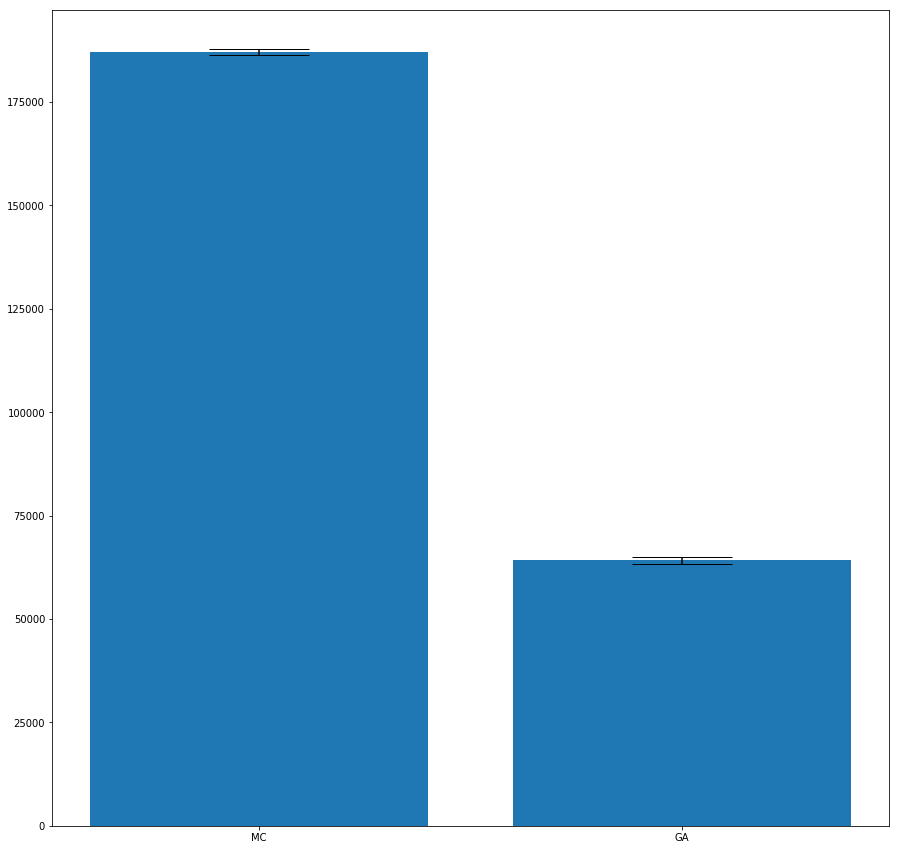

Monte Carlo mean = 187120.05 
 Monte Carlo SE =  645.5955368780382
GA mean =  64168.8 
 GA SE =  824.5519887219137


In [25]:
MC = newarray[:,0]
mut_CO = newarray[:,1]

# means of different methods
MC_mean = np.mean(newarray[:,0])
mut_CO_mean = np.mean(newarray[:,1])

# standard error of mean
MC_se = np.std(newarray[:,0]/(math.sqrt(runs-1)))
mut_CO_se = np.std(newarray[:,1])/math.sqrt(runs-1)

# data
height = [MC_mean, mut_CO_mean]
bars = ('MC', 'GA')
y_pos = np.arange(len(bars))
 
# Choose the height of the error bars (bars)
yer1 = [MC_se, mut_CO_se]

fig = plt.figure(figsize = (15,15))
# Create bars
plt.bar(y_pos, height, yerr = yer1, capsize = 50)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()

print('Monte Carlo mean =', MC_mean,'\n', 'Monte Carlo SE = ', MC_se)
print('GA mean = ', mut_CO_mean,'\n', 'GA SE = ', mut_CO_se)
